# Recommendation Systems: Amazon product reviews

We will work with the Amazon product reviews dataset for this project. The dataset contains ratings of different electronic products. It does not include information about the products or reviews to avoid bias while building the model.

--------------
### Context:
--------------

Online E-commerce websites like Amazon, Flipkart uses different recommendation models to provide personalized suggestions to different users. Amazon currently uses item-to-item collaborative filtering, which scales to massive data sets and produces high-quality recommendations in real-time.

----------------
### Objective:
----------------

Build a recommendation system to recommend products to customers based on their previous ratings for other products.

--------------
### Dataset:
--------------

The Amazon dataset contains the following attributes:

- **userId:** Every user identified with a unique id
- **productId:** Every product identified with a unique id
- **Rating:** Rating of the corresponding product by the corresponding user
- **timestamp:** Time of the rating (ignore this column for this exercise)

### Plan :
- Exploreing the data (sparse) and preparing it for recommendation system prediction task.
- Implementing ranking recommendation system and build recommender for user who has given more that 50 rankings.
- Building Collaborative Filtering based Recommendation System by finding similarities and utilizing it.
- Improving the collaborative filtering based system by using Singular Value Decomposition, evaluated cost function and drew recommendations.

### Importing Libraries

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics.pairwise import cosine_similarity

from sklearn.metrics import mean_squared_error

In [ ]:
!unzip /content/ratings_Electronics.csv.zip -d extracted_files/

Archive:  /content/ratings_Electronics.csv.zip
  inflating: extracted_files/ratings_Electronics (1).csv  


In [ ]:
df = pd.read_csv('/content/extracted_files/ratings_Electronics (1).csv', header=None) #There are no headers in the data file
df.head()

,0,1,2,3
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


### Loading data

In [ ]:
df.columns = ['user_id', 'prod_id', 'rating', 'timestamp'] #Adding column names

df = df.drop('timestamp', axis=1) #Dropping timestamp

df_copy = df.copy(deep=True) #Copying the data to another dataframe

In [ ]:
# see few rows of the imported dataset
df.head()

,user_id,prod_id,rating
0,AKM1MP6P0OYPR,0132793040,5.0
1,A2CX7LUOHB2NDG,0321732944,5.0
2,A2NWSAGRHCP8N5,0439886341,1.0
3,A2WNBOD3WNDNKT,0439886341,3.0
4,A1GI0U4ZRJA8WN,0439886341,1.0


### Exploratory Data Analysis

#### Shape of the data

In [ ]:
# Check the number of rows and columns
rows, columns = df.shape[0], df.shape[1]
print("No of rows: ", rows)
print("No of columns: ", columns)

No of rows:  7824482
No of columns:  3


#### Data types

In [ ]:
#Check Data types
df.dtypes

user_id     object
prod_id     object
rating     float64
dtype: object

#### Checking for missing values

In [ ]:
# Find number of missing values in each column
df.isna().sum()

user_id    0
prod_id    0
rating     0
dtype: int64

#### Summary Statistics

In [ ]:
# Summary statistics of 'rating' variable
df.describe()

,rating
count,7.824482e+06
mean,4.012337e+00
std,1.380910e+00
min,1.000000e+00
25%,3.000000e+00
50%,5.000000e+00
75%,5.000000e+00
max,5.000000e+00


#### Checking the rating distribution

Check the distribution of ratings and **provide observations** from the plot

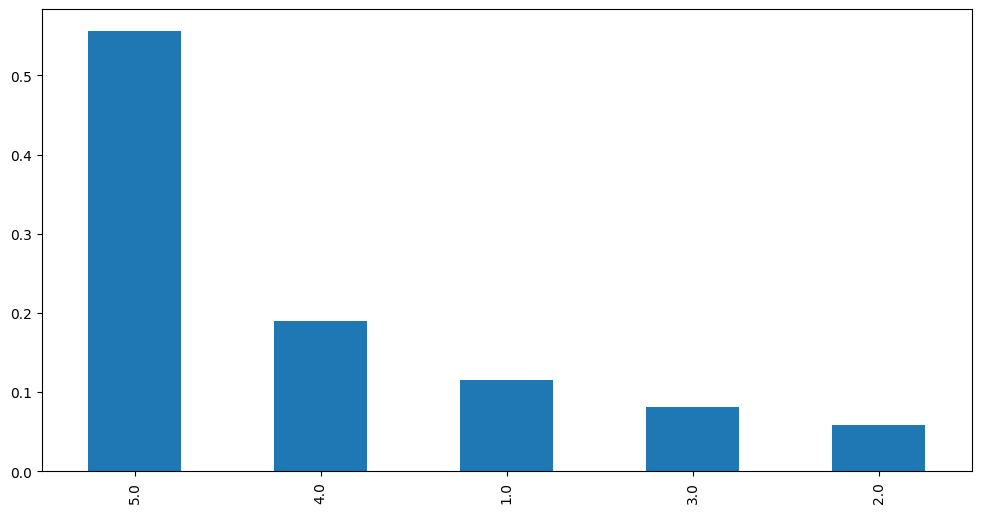

In [ ]:
#Create the plot and provide observations

plt.figure(figsize = (12,6))
df['rating'].value_counts(1).plot(kind='bar')
plt.show()

## Observations

- Around 75% of the ratings are positive (~55% is 5.0, and ~19% is 4.0). This shows that most users were happy with the products they rated.
- ~12% of the ratings is 1.0 and only ~5% is 2.0. It also gives positive idea about the products.



#### Checking the number of unique users and items in the dataset

In [ ]:
# Number of unique user id and product id in the data
print('Number of unique USERS in Raw data = ', df['user_id'].nunique())
print('Number of unique ITEMS in Raw data = ', df['prod_id'].nunique())

Number of unique USERS in Raw data =  4201696
Number of unique ITEMS in Raw data =  476002


- There are **4 201 696 users and 476 002 products** in the dataset



#### Users with most number of ratings

user_id
A5JLAU2ARJ0BO     520
ADLVFFE4VBT8      501
A3OXHLG6DIBRW8    498
A6FIAB28IS79      431
A680RUE1FDO8B     406
A1ODOGXEYECQQ8    380
A36K2N527TXXJN    314
A2AY4YUOX2N1BQ    311
AWPODHOB4GFWL     308
A25C2M3QF9G7OQ    296
dtype: int64


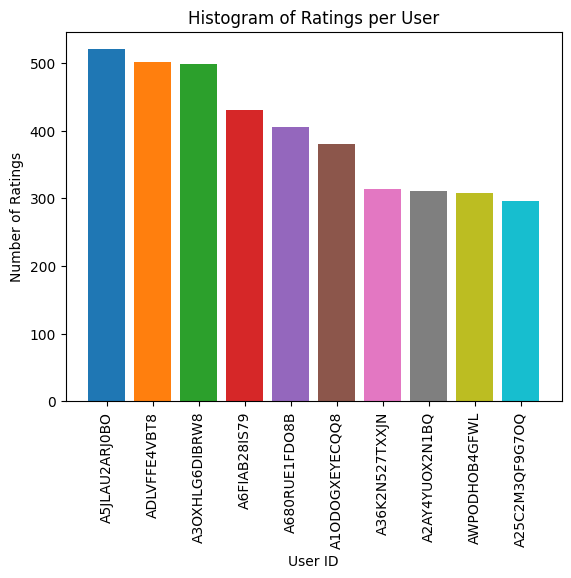

In [ ]:
# Top 10 users based on rating
Top_users = df.groupby('user_id').size().sort_values(ascending=False)[:10]
print (Top_users)
 # Create a histogram of the number of ratings per user
sns.color_palette("husl", 10)
plt.bar(Top_users.index, Top_users.values, color=sns.color_palette())

# Add labels and a title
plt.xlabel('User ID')
plt.ylabel('Number of Ratings')
plt.title('Histogram of Ratings per User')

# Rotate x-axis labels
plt.xticks(rotation=90)

# Show the plot
plt.show()

- The highest number of ratings by a user is 520 which is far from the actual number of products present in the data. We can build a recommendation system to recommend products to users which they have not interacted with.

### Data preparation

**Let's take a subset of the dataset to make the dataset less sparse and easy to work with (by only keeping the users who have given 50 or more ratings and also products that got at least 50 ratings :This is because items with very low numbers of ratings can skew the results. A product with only one rating has a solid chance of its only rating being 5 stars pushing it to the top, while a product that has been reviewed hundreds of times is likely to have at least one non-perfect review. ) .**

In [ ]:
# Count the occurrences of each value in column 'prod_id'
value_counts = df['prod_id'].value_counts()

# Get the values that occur more than 50 times
values_to_keep = value_counts[value_counts > 50].index

# Filter the DataFrame to keep only the rows with values occurring more than 3 times
df_final = df[df['prod_id'].isin(values_to_keep)]

df_final.head()

,user_id,prod_id,rating
183,A1BKC6B7YHYTVV,0972683275,4.0
184,AWVFSIB42LHKJ,0972683275,4.0
185,A36MQBNADRH8YY,0972683275,5.0
186,A3SRXMPLAEZ6DP,0972683275,4.0
187,A20XXTXWF2TCPY,0972683275,5.0


In [ ]:
print('The number of observations in the final data =', len(df_final))
print('Number of unique USERS in the final data = ', df_final['user_id'].nunique())
print('Number of unique PRODUCTS in the final data = ', df_final['prod_id'].nunique())

The number of observations in the final data = 5350913
Number of unique USERS in the final data =  3214962
Number of unique PRODUCTS in the final data =  25758


prod_id
B00178JC1C    51
B005DHL0EK    51
B0028N78HA    51
B00DSKW6QK    51
B0028AVGEO    51
B005DNR6CO    51
B005DSMNPO    51
B00DQZO3JK    51
B005EDAEZO    51
B005EJLFXI    51
dtype: int64


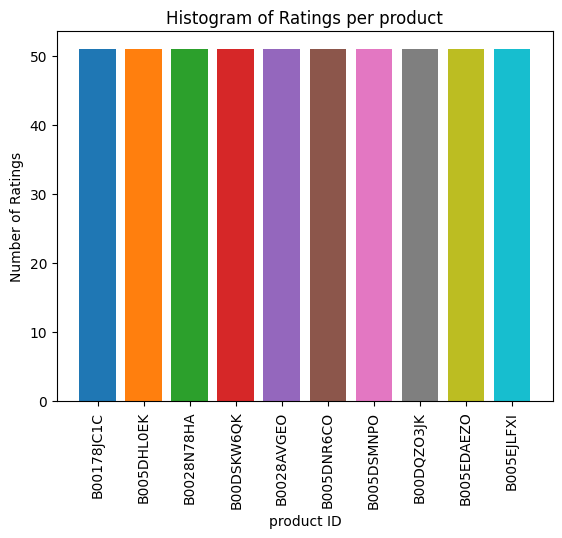

In [ ]:
# Top 10 users based on rating
most_rated = df_final.groupby('prod_id').size().sort_values(ascending=True)[:10]
print (most_rated)
 # Create a histogram of the number of ratings per user
sns.color_palette("husl", 10)
plt.bar(most_rated.index, most_rated.values, color=sns.color_palette())

# Add labels and a title
plt.xlabel('product ID')
plt.ylabel('Number of Ratings')
plt.title('Histogram of Ratings per product')

# Rotate x-axis labels
plt.xticks(rotation=90)

# Show the plot
plt.show()

In [ ]:
# Count the occurrences of each value in column 'user_id'
value_counts = df_final['user_id'].value_counts()

# Get the values that occur more than 50 times
values_to_keep = value_counts[value_counts > 50].index

# Filter the DataFrame to keep only the rows with values occurring more than 3 times
df_final = df_final[df_final['user_id'].isin(values_to_keep)]

df_final.head()

,user_id,prod_id,rating
631,A3TAS1AG6FMBQW,0972683275,5.0
1335,A2XIOXRRYX0KZY,1400501466,3.0
1777,A18S2VGUH9SCV5,1400501776,4.0
2162,A5JLAU2ARJ0BO,1400532655,1.0
2437,A3HPCRD9RX351S,1400532655,3.0


In [ ]:
print('The number of observations in the final data =', len(df_final))
print('Number of unique USERS in the final data = ', df_final['user_id'].nunique())
print('Number of unique PRODUCTS in the final data = ', df_final['prod_id'].nunique())

The number of observations in the final data = 41507
Number of unique USERS in the final data =  534
Number of unique PRODUCTS in the final data =  12246


user_id
A2L42QEWR77PKZ    51
A2NP9CGUSFP22E    51
A3OYO7B6SS7QLH    51
A9LNWA25IM2DX     51
A1GYEGLX3P2Y7P    51
A33XMCG1UFDSY2    51
AGXV8E7XK9J6H     51
A2Y1WNETD9AYHO    51
AB094YABX21WQ     51
A361M14PU2GUEG    51
dtype: int64


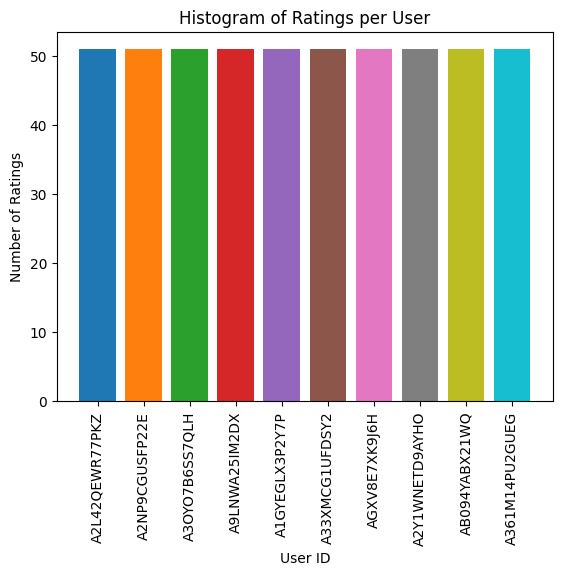

In [ ]:
# Top 10 users based on rating
Top_users = df_final.groupby('user_id').size().sort_values(ascending=True)[:10]
print (Top_users)
 # Create a histogram of the number of ratings per user
sns.color_palette("husl", 10)
plt.bar(Top_users.index, Top_users.values, color=sns.color_palette())

# Add labels and a title
plt.xlabel('User ID')
plt.ylabel('Number of Ratings')
plt.title('Histogram of Ratings per User')

# Rotate x-axis labels
plt.xticks(rotation=90)

# Show the plot
plt.show()

- The dataframe **df_final has users who have rated 50 or more items**
- **We will use df_final to build recommendation systems**

#### Checking the density of the rating matrix

In [ ]:
#Creating the interaction matrix of products and users based on ratings and replacing NaN value with 0
final_ratings_matrix = df_final.pivot(index = 'user_id', columns ='prod_id', values = 'rating').fillna(0)
print('Shape of final_ratings_matrix: ', final_ratings_matrix.shape)

#Finding the number of non-zero entries in the interaction matrix
given_num_of_ratings = np.count_nonzero(final_ratings_matrix)
print('given_num_of_ratings = ', given_num_of_ratings)

#Finding the possible number of ratings as per the number of users and products
possible_num_of_ratings = final_ratings_matrix.shape[0] * final_ratings_matrix.shape[1]
print('possible_num_of_ratings = ', possible_num_of_ratings)

#Density of ratings
density = (given_num_of_ratings/possible_num_of_ratings)
density *= 100
print ('density: {:4.2f}%'.format(density))

final_ratings_matrix.head()

Shape of final_ratings_matrix:  (1540, 48190)
given_num_of_ratings =  125871
possible_num_of_ratings =  74212600
density: 0.17%


prod_id,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
user_id,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10AFVU66A79Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


- Even with the subset of users and products, the current number of ratings is just **0.17%** of the possible number of ratings. This implies that the data is **highly sparse**.
- We will build recommendation systems to recommend products to users with which they have not interacted.

Now that we have explored and preprocessed the data, let's build the first recommendation system

### Rank Based Recommendation System

In [ ]:
#Calculate the average rating for each product
average_rating = df_final.groupby(['prod_id']).mean().rating
print(average_rating.head())
#Calculate the count of ratings for each product
count_rating = df_final.groupby(['prod_id']).count().rating

#Create a dataframe with calculated average and count of ratings
final_rating = pd.DataFrame(pd.concat([average_rating,count_rating], axis = 1))
final_rating.columns=["Average Rating", "Ratings Count"]

#Sort the dataframe by average of ratings
final_rating = final_rating.sort_values(by='Average Rating', ascending=False)
final_rating.head()

#finaal_rating = final_rating.sort_values(by='Ratings Count', ascending=False)
#finaal_rating.head()

In [ ]:
final_rating.head()

,Average Rating,Ratings Count
prod_id,,
B002E6R7NG,4.980392,51
B004I763AW,4.966667,60
B003J9QQWU,4.964286,56
B0043ZLFXE,4.955556,90
B000TMFYBO,4.953125,64


In [ ]:
#defining a function to get the top n products based on highest average rating and minimum interactions
def top_n_products(final_rating, n, min_interaction):

    #Finding movies with minimum number of interactions
    recommendations = final_rating[final_rating['Ratings Count'] >= min_interaction]

    return recommendations.index[:n]

#### Recommending top 5 products with 100 minimum interactions based on popularity

In [ ]:
list(top_n_products(final_rating, 5, 100))

['B00GMRCAC6', 'B008I6RVZU', 'B00CG70K78', 'B000053HC5', 'B008VGCT9K']

#### Recommending top 5 products with 100 minimum interactions based on popularity

In [ ]:
list(top_n_products(final_rating, 10, 200))

['B00CG70K78',
 'B008VGCT9K',
 'B0033PRWSW',
 'B007SZ0E1K',
 'B005LJQPE0',
 'B002NEGTSI',
 'B0043WJRRS',
 'B0041OYTJE',
 'B006TAP096',
 'B001BTCSI6']

We have recommended the top 5 products by using popularity recommendation system. Now, let's build a recommendation system using collaborative filtering

### Collaborative Filtering based Recommendation System

In [ ]:
final_ratings_matrix = df_final.pivot(index = 'user_id', columns ='prod_id', values = 'rating')
print('Shape of final_ratings_matrix: ', final_ratings_matrix.shape)
matrix_w_NANs = final_ratings_matrix.copy()

final_ratings_matrix.head()

Shape of final_ratings_matrix:  (534, 12246)


prod_id,0972683275,1400501466,1400501776,1400532655,9983891212,B000001OM4,B000001OM5,B000001OMI,B000001ON6,B00000DM9W,...,B00JP12170,B00JX1ZS5O,B00K0OBEE2,B00K4VQZCM,B00K7O2DJU,B00K91DB7Y,B00KFAGCUM,B00KINSDK8,B00KWHMR6G,B00L3YHF6O
user_id,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A100WO06OQR8BQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
A105TOJ6LTVMBG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A10NMELR4KX0J6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A10O7THJ2O20AG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
avg_ratings = final_ratings_matrix.mean(axis=1)
final_ratings_matrix = final_ratings_matrix.sub(avg_ratings, axis=0)

final_ratings_matrix.head()

prod_id,0972683275,1400501466,1400501776,1400532655,9983891212,B000001OM4,B000001OM5,B000001OMI,B000001ON6,B00000DM9W,...,B00JP12170,B00JX1ZS5O,B00K0OBEE2,B00K4VQZCM,B00K7O2DJU,B00K91DB7Y,B00KFAGCUM,B00KINSDK8,B00KWHMR6G,B00L3YHF6O
user_id,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A100WO06OQR8BQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-2.59596,NaN,NaN,NaN,NaN
A105TOJ6LTVMBG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A10NMELR4KX0J6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A10O7THJ2O20AG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
final_ratings_matrix = final_ratings_matrix.fillna(0)
matrix_filled = final_ratings_matrix.copy()
final_ratings_matrix.head()

prod_id,0972683275,1400501466,1400501776,1400532655,9983891212,B000001OM4,B000001OM5,B000001OMI,B000001ON6,B00000DM9W,...,B00JP12170,B00JX1ZS5O,B00K0OBEE2,B00K4VQZCM,B00K7O2DJU,B00K91DB7Y,B00KFAGCUM,B00KINSDK8,B00KWHMR6G,B00L3YHF6O
user_id,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-2.59596,0.0,0.0,0.0,0.0
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0
A10NMELR4KX0J6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0
A10O7THJ2O20AG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0


In [ ]:
non_null_values = matrix_w_NANs['0972683275'].notnull()

print(matrix_w_NANs['0972683275'][non_null_values])

user_id
A3TAS1AG6FMBQW    5.0
Name: 0972683275, dtype: float64


**Here, user_id (index) is of the object data type. We will replace the user_id by numbers starting from 0 to 1539 (for all user ids) so that the index is of integer type and represents a user id in the same format**

In [ ]:
final_ratings_matrix['user_index'] = np.arange(0, final_ratings_matrix.shape[0])
final_ratings_matrix.set_index(['user_index'], inplace=True)

# Actual ratings given by users
final_ratings_matrix.head()

prod_id,0972683275,1400501466,1400501776,1400532655,9983891212,B000001OM4,B000001OM5,B000001OMI,B000001ON6,B00000DM9W,...,B00JP12170,B00JX1ZS5O,B00K0OBEE2,B00K4VQZCM,B00K7O2DJU,B00K91DB7Y,B00KFAGCUM,B00KINSDK8,B00KWHMR6G,B00L3YHF6O
user_index,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-2.59596,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0


Now, let's define a **function to get similar users**  , in other terms, users that share the same rating pattren with a particular user.

In [ ]:
# defining a function to get similar users
def similar_users(user_index, interactions_matrix):
    similarity = []
    for user in range(0, interactions_matrix.shape[0]):

        #finding cosine similarity between the user_id and each user
        sim = cosine_similarity([interactions_matrix.loc[user_index]], [interactions_matrix.loc[user]])

        #Appending the user and the corresponding similarity score with user_id as a tuple
        similarity.append((user, sim))

    similarity.sort(key=lambda x: x[1], reverse=True)
    most_similar_users = [Tuple[0] for Tuple in similarity] #Extract the user from each tuple in the sorted list
    similarity_score = [Tuple[1] for Tuple in similarity]   ##Extracting the similarity score from each tuple in the sorted list

    #Remove the original user and its similarity score and keep only other similar users
    most_similar_users.remove(user_index)
    similarity_score.remove(similarity_score[0])

    return most_similar_users, similarity_score

#### Finding out top 10 similar users to the user index 3 and their similarity score

In [ ]:
similar = similar_users(3, final_ratings_matrix)[0][0:10]
similar

[677, 1316, 1305, 534, 283, 1309, 75, 386, 90, 917]

In [ ]:
#Print the similarity score
similar_users(3,final_ratings_matrix)[1][0:10]

[array([[0.07763344]]),
 array([[0.04701875]]),
 array([[0.04664611]]),
 array([[0.04579965]]),
 array([[0.04579864]]),
 array([[0.04446317]]),
 array([[0.04088303]]),
 array([[0.03612803]]),
 array([[0.03596268]]),
 array([[0.03296822]])]

#### Finding out top 10 similar users to the user index 1521 and their similarity score

In [ ]:
similar = similar_users(1521, final_ratings_matrix)[0][0:10]
similar

[248, 1121, 939, 940, 309, 1038, 689, 723, 86, 1218]

In [ ]:
#Print the similarity score
similar_users(1521, final_ratings_matrix)[1][0:10]

[array([[0.10350989]]),
 array([[0.07880711]]),
 array([[0.07728824]]),
 array([[0.07484275]]),
 array([[0.07207623]]),
 array([[0.06542865]]),
 array([[0.06468087]]),
 array([[0.06365991]]),
 array([[0.0618141]]),
 array([[0.06173052]])]

We have found similar users for a given user. Now, let's create **a function to recommend products** to the user using the ratings given by similar users.

In [ ]:
# defining the recommendations function to get recommendations by using the similar users' preferences
def recommendations(user_index, num_of_products, interactions_matrix):

    #Saving similar users using the function similar_users defined above
    most_similar_users = similar_users(user_index, interactions_matrix)[0]

    #Finding product IDs with which the user_id has interacted
    prod_ids = set(list(interactions_matrix.columns[np.where(interactions_matrix.loc[user_index] > 0)]))
    recommendations = []

    observed_interactions = prod_ids.copy()
    for similar_user in most_similar_users:
        if len(recommendations) < num_of_products:

            #Finding 'n' products which have been rated by similar users but not by the user_id
            similar_user_prod_ids = set(list(interactions_matrix.columns[np.where(interactions_matrix.loc[similar_user] > 0)]))
            recommendations.extend(list(similar_user_prod_ids.difference(observed_interactions)))
            observed_interactions = observed_interactions.union(similar_user_prod_ids)
        else:
            break

    return recommendations[:num_of_products]

#### Recommend 5 products to user index 3 based on similarity based collaborative filtering

In [ ]:
recommendations(3, 5, final_ratings_matrix)

['B006TT91TW', 'B004N623WK', 'B000068O6G', 'B00DTRHB2G', 'B0045KGZOG']

#### Recommend 5 products to user index 1521 based on similarity based collaborative filtering

In [ ]:
recommendations(1521, 5, final_ratings_matrix)

['B0001ILYPQ', 'B00005AC8W', 'B001ULD4L0', 'B00006IW1X', 'B008DJTB32']

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
user_knn = KNeighborsRegressor(metric='cosine', n_neighbors=3)
user_knn.fit(other_users_x, other_users_y)
user_user_pred = user_knn.predict(target_user_x)
print(user_user_pred)